# NLモデルの推定2
以下の写真のモデル構造のものを推定する


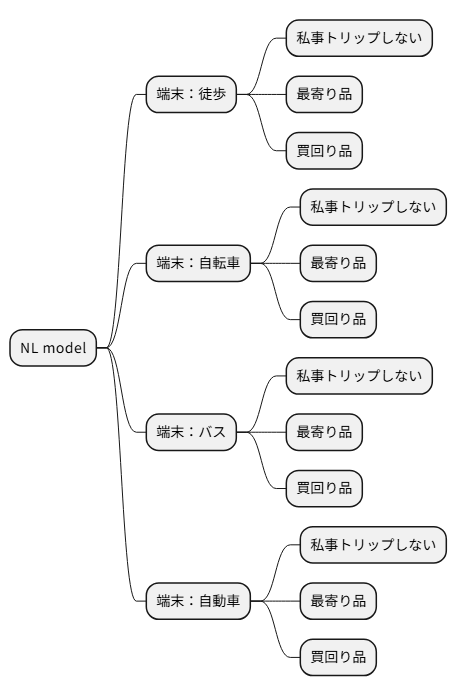

In [1]:
# ライブラリの導入
import pandas as pd
import biogeme.biogeme_logging as blog

from biogeme.database import Database
from biogeme.expressions import Variable, Beta
from biogeme.biogeme import BIOGEME
from biogeme.models import lognested
from biogeme.nests import OneNestForNestedLogit, NestsForNestedLogit
from biogeme.results_processing import get_pandas_estimated_parameters

/home/shibumtk/B4research/estimate/.venv/lib/python3.12/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# 入力データの読み込み
master_df = pd.read_csv("/home/shibumtk/B4research/estimate/data/01master_data/NL_Logit_master1.csv", encoding="utf-8-sig")
master_df = master_df.fillna(0) # 欠損値を一応埋める

# 文字列は除外する
drop_cols =['NearestStation', 'WorkplaceStation']
master_df = master_df.drop(columns=drop_cols)

# NL用のCHOICEカラムを作成する
mode_map = {1:0, 2:1, 4:2, 5:3} # 端末手段を0~3にまとめる
priv_map = {0:0, 1:1, 2:2} # 私事なしと私事種類で0~2でまとめる
# 書き換え（のちに12種類の選択肢にするため）
master_df["t_first_transportation"] = master_df["first_transportation"].map(mode_map)
master_df["t_PriTrip_class"] = master_df["PriTrip_class"].map(priv_map)
# CHOICEカラムの作成（1~12が入力される）
master_df["CHOICE"] = (3 * master_df["t_first_transportation"] + master_df["t_PriTrip_class"] + 1).astype(int)

# 確認
print(len(master_df))
print(master_df["CHOICE"].isna().sum())
master_df.columns

49034
0


Index(['Personal_ID', 'HouseholdIncome', 'sex', 'age', 'JobType',
       'ComuTime[m]', 'MainlineTime[m]', 'AccessTime_used[m]', 'HouseholdType',
       'HouseholdMembers(all)', 'YoungestMember_No', 'WorkTime[m]',
       'AfterTime_work[m]', 'AfterTime_home[m]', 'first_transportation',
       'NearestStation_code', 'near_area_syou', 'near_area_kinrin',
       'near_area_sum', 'near_area_syou500', 'near_area_kinrin500',
       'near_area_sum500', 'near_area_syou300', 'near_area_kinrin300',
       'near_area_sum300', 'near_o_area_syou', 'near_o_area_kinrin',
       'near_o_area_sum', 'near_o_area_syou500', 'near_o_area_kinrin500',
       'near_o_area_sum500', 'near_o_area_syou300', 'near_o_area_kinrin300',
       'near_o_area_sum300', 'WorkplaceStation_code', 'WP_area_syou',
       'WP_area_kinrin', 'WP_area_sum', 'WP_area_syou500', 'WP_area_kinrin500',
       'WP_area_sum500', 'WP_area_syou300', 'WP_area_kinrin300',
       'WP_area_sum300', 'WP_o_area_syou', 'WP_o_area_kinrin', 'WP_o_ar

In [3]:
# CHOICEの数を確認
master_df["CHOICE"].value_counts().sort_index()

CHOICE
1     29318
2      3121
3      4411
4      4612
5       459
6       468
7      4432
8       316
9       478
10     1234
11       69
12      116
Name: count, dtype: int64

In [4]:
# biogemeデータリストに格納する
master_db = Database("PTdata", master_df)

In [ ]:
# 変数の定義
# output
CHOICE = Variable("CHOICE")

# input
# traffic_mode
WALK_AV    = Variable("walk_av")
WALK_TT    = Variable("walk_time[m]")
BICYCLE_AV = Variable("bicycle_av")
BICYCLE_TT = Variable("bicycle_time[m]")
BUS_AV     = Variable("bus_av")
BUS_TT     = Variable("bus_time[m]")
CAR_AV     = Variable("car_av")
CAR_TT     = Variable("car_time[m]")

# Trip_choice
WORKTIME    = Variable("WorkTime[m]")
AF_WORKTIME = Variable("AfterTime_work[m]") # AF=after
MACMTIME    = Variable("MainlineTime[m]") # 通勤メイン時間
HHM_all     = Variable("HouseholdMembers(all)") # 世帯人数
NEKI_INDEX  = Variable("near_area_syou300") # 最寄駅土地利用指標
WEKI_INDEX  = Variable("WP_area_syou300") # 就業地駅土地利用指標

# scaled
WORKTIME_SCALED    = master_db.define_variable("WORKTIME_SCALED", WORKTIME / 60)
AF_WORKTIME_SCALED = master_db.define_variable("AF_WORKTIME_SCALED", AF_WORKTIME / 60)
MACMTIME_SCALED    = master_db.define_variable("MACMTIME_SCALED", MACMTIME / 60) # 1時間当たりの変化

NEKI_INDEX_SCALED = master_db.define_variable("NEKI_INDEX_SCALED", NEKI_INDEX / 1000000)
WEKI_INDEX_SCALED = master_db.define_variable("WEKI_INDEX_SCALED", WEKI_INDEX / 1000000)

# alternative specific constant
# traffic mode
ASC_WALK = Beta("ASC_WALK", 0, None, None, 1)  # fixed base
ASC_BIC  = Beta("ASC_BIC",  0, None, None, 0)
ASC_BUS  = Beta("ASC_BUS",  0, None, None, 0)
ASC_CAR  = Beta("ASC_CAR",  0, None, None, 0)
# Trip_choice
ASC_NOTRIP     = Beta("ASC_NOTRIP", 0, None, None, 1)  # 私事トリップなし固定
ASC_DUTY       = Beta("ASC_DUTY",   0, None, None, 0)  # 義務
ASC_DISCRETION = Beta("ASC_DISCRETION", 0, None, None, 0)  # 裁量

# parameters
b_at = Beta("b_at", 1.0, None, None, 0)

b_work        = Beta("b_work", 1.0, None, None, 0)
b_aftime_work = Beta("aftime_work", 1.0, None, None, 0)
b_macmtime    = Beta("MACM", 1.0, None, None, 0)
b_hhm         = Beta("b_hhm", 1.0, None, None, 0)
b_n_eki       = Beta("b_n_eki", 1.0, None, None, 0)
b_w_eki       = Beta("b_w_eki", 1.0, None, None, 0)

MU_MODE = Beta("MU_MODE", 1.0, 1.0, 10.0, 0) # ネストパラメータ

# Alternative_ID（選択肢の説明）
W_NO, W_DUTY, W_DISCRETION = 1, 2, 3
BI_NO, BI_DUTY, BI_DISCRETION = 4, 5, 6 # 自転車
BU_NO, BU_DUTY, BU_DISCRETION = 7, 8, 9 # バス
C_NO, C_DUTY, C_DISCRETION = 10, 11, 12

# Utility（効用関数）
# mode
V_WALK_MODE = ASC_WALK + b_at * WALK_TT
V_BIC_MODE  = ASC_BIC  + b_at * BICYCLE_TT
V_BUS_MODE  = ASC_BUS  + b_at * BUS_TT
V_CAR_MODE  = ASC_CAR  + b_at * CAR_TT
# PriTrip
V_NO_PRIVATE     = ASC_NOTRIP
V_DUTY_PRI       = (ASC_DUTY
                    + b_work     * WORKTIME_SCALED
                    + b_macmtime * MACMTIME_SCALED
                    + b_n_eki    * NEKI_INDEX_SCALED
                    + b_hhm      * HHM_all)

V_DISCRETION_PRI = (ASC_DISCRETION
                    + b_work     * WORKTIME_SCALED
                    + b_macmtime * MACMTIME_SCALED
                    + b_n_eki    * NEKI_INDEX_SCALED
                    + b_hhm      * HHM_all)

# for 12alternative
V = {
    W_NO:         V_WALK_MODE + V_NO_PRIVATE,
    W_DUTY:       V_WALK_MODE + V_DUTY_PRI,
    W_DISCRETION: V_WALK_MODE + V_DISCRETION_PRI,

    BI_NO:         V_BIC_MODE + V_NO_PRIVATE,
    BI_DUTY:       V_BIC_MODE + V_DUTY_PRI,
    BI_DISCRETION: V_BIC_MODE + V_DISCRETION_PRI,

    BU_NO:         V_BUS_MODE + V_NO_PRIVATE,
    BU_DUTY:       V_BUS_MODE + V_DUTY_PRI,
    BU_DISCRETION: V_BUS_MODE + V_DISCRETION_PRI,

    C_NO:         V_CAR_MODE + V_NO_PRIVATE,
    C_DUTY:       V_CAR_MODE + V_DUTY_PRI,
    C_DISCRETION: V_CAR_MODE + V_DISCRETION_PRI,
}

# availability
av = {
    W_NO : WALK_AV,      W_DUTY: WALK_AV,      W_DISCRETION: WALK_AV,
    BI_NO: BICYCLE_AV,  BI_DUTY: BICYCLE_AV,  BI_DISCRETION: BICYCLE_AV,
    BU_NO: BUS_AV,      BU_DUTY: BUS_AV,      BU_DISCRETION: BUS_AV,
    C_NO : CAR_AV,       C_DUTY: CAR_AV,       C_DISCRETION: CAR_AV
}

# nests(upper level = mode)
nest_walk = OneNestForNestedLogit(MU_MODE, [W_NO,  W_DUTY,  W_DISCRETION],  name="walk")
nest_bic  = OneNestForNestedLogit(MU_MODE, [BI_NO, BI_DUTY, BI_DISCRETION], name="bicycle")
nest_bus  = OneNestForNestedLogit(MU_MODE, [BU_NO, BU_DUTY, BU_DISCRETION], name="bus")
nest_car  = OneNestForNestedLogit(MU_MODE, [C_NO,  C_DUTY,  C_DISCRETION],  name="car")

nests = NestsForNestedLogit(
    choice_set=list(V.keys()),
    tuple_of_nests=(nest_walk, nest_bic, nest_bus, nest_car),
)

: 

In [ ]:
#estimate
logprob = lognested(V, av, nests, CHOICE)

logger = blog.get_screen_logger(level=blog.INFO)
biogeme = BIOGEME(master_db, logprob, 
                  generate_html=False, generate_yaml=False, # 推定結果保存可否
                  optimization_algorithm="simple_bounds_BFGS")
biogeme.model_name = "NL_mode_then_private3"

biogeme.calculate_null_loglikelihood(av)
results = biogeme.estimate()

print(results.short_summary())

# パラメータ推定値をpandasに格納して表示
pandas_results = get_pandas_estimated_parameters(estimation_results=results)
print(pandas_results)

Biogeme parameters read from biogeme.toml. 


*** Initial values of the parameters are obtained from the file __NL_mode_then_private3.iter 
Parameter values restored from __NL_mode_then_private3.iter 
Starting values for the algorithm: {'b_at': 1.0, 'MU_MODE': 1.0, 'ASC_DUTY': 0.0, 'b_work': 1.0, 'MACM': 1.0, 'b_n_eki': 1.0, 'b_hhm': 1.0, 'ASC_DISCRETION': 0.0, 'ASC_BIC': 0.0, 'ASC_BUS': 0.0, 'ASC_CAR': 0.0} 
Optimization algorithm: BFGS with simple bounds [simple_bounds_BFGS]. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: BFGS with trust region for simple bounds 
E1226 00:37:27.964292   70577 slow_operation_alarm.cc:73] 
********************************
[Compiling module jit_sum_function for CPU] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
E1226 00:38:01.140706   70514 slow_operation_alarm.cc:140] The operation took 2m33.178319265s

********************************
[Compili